In [241]:
import pandas as pd
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.linear_model import LogisticRegression
from mlxtend.frequent_patterns import apriori, association_rules
from sklearn.svm import SVC
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, roc_auc_score, confusion_matrix, classification_report
import matplotlib.pyplot as plt
import seaborn as sns

In [ ]:
df = pd.read_csv('data/data_cleaned.csv', na_values=['NA'])
# Selecting only numeric type columns
numeric_df = df.select_dtypes(include=['number'])
# Calculating correlations based on treatment column
correlations = numeric_df.corr()['treatment'].sort_values(ascending=False)
print(correlations)


treatment                    1.000000
family_history               0.376674
work_interfere               0.301096
care_options                 0.272083
obs_consequence              0.152524
leave                        0.141701
mental_health_consequence    0.093062
seek_help                    0.085215
wellness_program             0.080151
Age                          0.073627
coworkers                    0.057944
benefits                     0.029501
phys_health_consequence      0.028123
remote_work                  0.026507
mental_health_interview      0.020537
self_employed                0.016442
no_employees                 0.013811
mental_vs_physical           0.006254
supervisor                  -0.024070
tech_company                -0.032521
anonymity                   -0.033870
Gender                      -0.186721
Name: treatment, dtype: float64


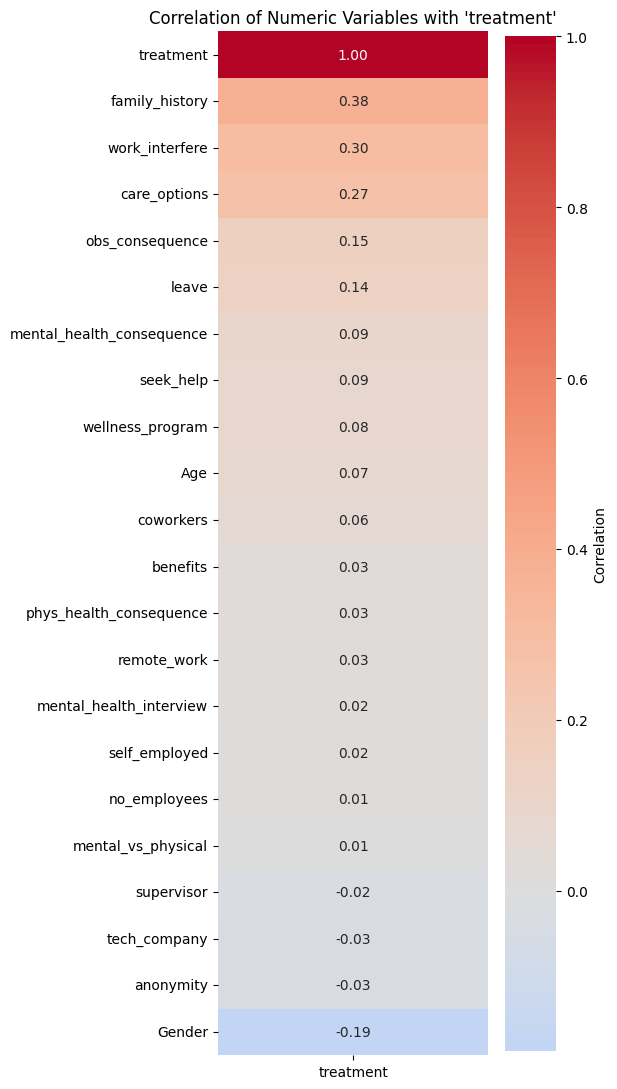

In [250]:
plt.figure(figsize=(6, len(correlations) * 0.5))  # Adjust height dynamically
sns.heatmap(
    correlations.to_frame(),  # Convert Series to DataFrame
    annot=True,
    fmt=".2f",
    cmap="coolwarm",
    center=0,
    cbar_kws={'label': 'Correlation'}
)
plt.title("Correlation of Numeric Variables with 'treatment'")
plt.yticks(rotation=0)
plt.tight_layout()
plt.show()

In [ ]:
cols = [
    'Gender', 'self_employed', 'family_history', 'treatment',
    'remote_work', 'tech_company', 'benefits', 'care_options',
    'wellness_program', 'seek_help', 'anonymity',
    'mental_health_consequence', 'phys_health_consequence',
    'coworkers', 'supervisor', 'mental_health_interview', 'mental_vs_physical',
    'obs_consequence'
]
df_bin = df[cols].fillna(0).astype(int)

# Using apriori, to see what features occur together
frequent_itemsets = apriori(df_bin, min_support=0.1, use_colnames=True)
# generating rules from these feature itemsets
rules = association_rules(
    frequent_itemsets,
    metric="confidence",
    min_threshold=0.6)

# Finding rules that include treatment, because that is what we want to predict
treatment_rules = rules[rules['consequents'].apply(lambda x: 'treatment' in x)]
treatment_rules = treatment_rules.sort_values(by='lift', ascending=False)
print("Top treatment rules:\n", treatment_rules[
    ['antecedents', 'consequents', 'support', 'confidence', 'lift']
    ].head())

# Creating the rules

for i, rule in enumerate(treatment_rules['antecedents'].head(5)):
    feature_name = f'rule_{i+1}'
    cols_in_rule = list(rule)  # convert frozenset to list
    df[feature_name] = df_bin[cols_in_rule].all(axis=1).astype(int)


rule_features = [f'rule_{i+1}' for i in range(5)]

Top treatment rules:
                                     antecedents  \
1298  (care_options, anonymity, family_history)   
727              (care_options, family_history)   
712              (care_options, family_history)   
1301             (care_options, family_history)   
1299   (care_options, family_history, benefits)   

                           consequents   support  confidence      lift  
1298             (treatment, benefits)  0.101519    0.658031  1.817212  
727            (supervisor, treatment)  0.102318    0.618357  1.807395  
712              (treatment, benefits)  0.106315    0.642512  1.774355  
1301  (anonymity, treatment, benefits)  0.101519    0.613527  1.748341  
1299            (anonymity, treatment)  0.101519    0.808917  1.700765  


C:\Users\Svennu\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\mlxtend\frequent_patterns\fpcommon.py:161: DeprecationWarning: DataFrames with non-bool types result in worse computationalperformance and their support might be discontinued in the future.Please use a DataFrame with bool type
  warnings.warn(


In [ ]:
# Creating new features by multiplying columns
df['work_leave_interaction'] = df['work_interfere'] * df['leave']
df['family_work_interaction'] = df['family_history'] * df['work_interfere']

# Selecting the top features for modeling
top_features = [
    'work_interfere', 'leave', 'no_employees',
    'family_history', 'care_options', 'obs_consequence',
    'work_leave_interaction', 'family_work_interaction'
] + rule_features

# Model data prep

X = df[top_features]
y = df['treatment']

In [ ]:

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

# Logistic Regression model

model = LogisticRegression(max_iter=1000)
# Fitting the model based on training data
model.fit(X_train, y_train)


# Making the predictions and Evaluating performancec
y_pred = model.predict(X_test)
print("Accuracy:", accuracy_score(y_test, y_pred))
print("ROC-AUC:", roc_auc_score(y_test, y_pred))
print("Confusion Matrix:\n", confusion_matrix(y_test, y_pred))

Accuracy: 0.7529880478087649
ROC-AUC: 0.7531432562865126
Confusion Matrix:
 [[95 29]
 [33 94]]


Random Forest model

In [ ]:
rf = RandomForestClassifier(
    n_estimators=80,     
    max_depth=11, 
    min_samples_split=10,
    min_samples_leaf=2,       
    random_state=42,
    class_weight='balanced'  
)

# Fitting the model based on training data
rf.fit(X_train, y_train)

# Predictions
y_pred = rf.predict(X_test)
y_proba = rf.predict_proba(X_test)[:, 1]

# Evaluation
print("Random Forest Accuracy:", accuracy_score(y_test, y_pred))
print("ROC-AUC:", roc_auc_score(y_test, y_proba))
print("Confusion Matrix:\n", confusion_matrix(y_test, y_pred))
print("\nClassification Report:\n", classification_report(y_test, y_pred))


Random Forest Accuracy: 0.796812749003984
ROC-AUC: 0.8330899161798323
Confusion Matrix:
 [[101  23]
 [ 28  99]]

Classification Report:
               precision    recall  f1-score   support

         0.0       0.78      0.81      0.80       124
         1.0       0.81      0.78      0.80       127

    accuracy                           0.80       251
   macro avg       0.80      0.80      0.80       251
weighted avg       0.80      0.80      0.80       251

